In [2]:
import numpy as np
import pandas as pd
import string
from rapidfuzz import fuzz

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv("train.csv")[["question1","question2","is_duplicate"]].dropna()
print(df.shape)
df.head()

(404287, 3)


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
punct = str.maketrans("", "", string.punctuation)

def fast_clean(text):
    text = str(text).lower().translate(punct)
    return " ".join([tok for tok in text.split() if tok.isalpha()])


In [5]:
df["q1_c"] = df.question1.apply(fast_clean)
df["q2_c"] = df.question2.apply(fast_clean)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df[["q1_c","q2_c"]],
    df.is_duplicate,
    test_size=0.2,
    random_state=42,
    stratify=df.is_duplicate
)


In [7]:
def hybrid_features(df):
    feats = []
    for q1, q2 in zip(df["q1_c"], df["q2_c"]):
        s1, s2 = set(q1.split()), set(q2.split())
        common = len(s1 & s2)
        total = max(len(s1 | s2), 1)
        overlap = common / total
        len_diff = abs(len(q1.split()) - len(q2.split()))

        f1 = fuzz.QRatio(q1, q2)
        f2 = fuzz.partial_ratio(q1, q2)
        f3 = fuzz.token_sort_ratio(q1, q2)
        f4 = fuzz.token_set_ratio(q1, q2)

        feats.append([common, overlap, len_diff, f1, f2, f3, f4])
    return np.array(feats)

eng_train = hybrid_features(X_train)
eng_test = hybrid_features(X_test)


In [8]:
tfidf_q1 = TfidfVectorizer(max_features=40000, ngram_range=(1,2))
tfidf_q2 = TfidfVectorizer(max_features=40000, ngram_range=(1,2))

Xq1_train = tfidf_q1.fit_transform(X_train.q1_c)
Xq1_test  = tfidf_q1.transform(X_test.q1_c)

Xq2_train = tfidf_q2.fit_transform(X_train.q2_c)
Xq2_test  = tfidf_q2.transform(X_test.q2_c)


In [9]:
def cosine_rowwise(A, B):
    sims = []
    for i in range(A.shape[0]):
        sims.append(cosine_similarity(A[i], B[i])[0][0])
    return np.array(sims).reshape(-1,1)

cos_train = cosine_rowwise(Xq1_train, Xq2_train)
cos_test  = cosine_rowwise(Xq1_test,  Xq2_test)


In [10]:
X_train_vec = hstack([Xq1_train, Xq2_train, eng_train, cos_train])
X_test_vec  = hstack([Xq1_test,  Xq2_test,  eng_test, cos_test])

In [11]:
lr = LogisticRegression(max_iter=500, n_jobs=-1)
svm = LinearSVC()

lr.fit(X_train_vec, y_train)
svm.fit(X_train_vec, y_train)

print("\n=== LOGISTIC REGRESSION ===\n", classification_report(y_test, lr.predict(X_test_vec)))
print("\n=== SVM ===\n", classification_report(y_test, svm.predict(X_test_vec)))


c:\Users\KIIT0001\Desktop\DL PROJECTS\Duplicate-Question\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\KIIT0001\Desktop\DL PROJECTS\Duplicate-Question\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== LOGISTIC REGRESSION ===
               precision    recall  f1-score   support

           0       0.81      0.85      0.83     51005
           1       0.71      0.65      0.68     29853

    accuracy                           0.77     80858
   macro avg       0.76      0.75      0.75     80858
weighted avg       0.77      0.77      0.77     80858


=== SVM ===
               precision    recall  f1-score   support

           0       0.85      0.86      0.85     51005
           1       0.76      0.73      0.74     29853

    accuracy                           0.81     80858
   macro avg       0.80      0.80      0.80     80858
weighted avg       0.81      0.81      0.81     80858



In [12]:
xgb = XGBClassifier(
    eval_metric='logloss',
    tree_method='hist',
    n_estimators=400,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

param_dist = {
    "max_depth": [4,6,8],
    "n_estimators": [300,500,800],
    "learning_rate": [0.05, 0.1],
    "min_child_weight": [1,3,5],
    "subsample": [0.8,1],
    "colsample_bytree": [0.8,1]
}

rs = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=5,
    scoring="f1",
    cv=2,
    verbose=2,
    n_jobs=1
)

rs.fit(X_train_vec, y_train)
best_xgb = rs.best_estimator_
pred_xgb = best_xgb.predict(X_test_vec)

print("\n=== XGBOOST RESULTS ===\n", classification_report(y_test, pred_xgb))
print("\nBEST PARAMS:\n", rs.best_params_)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=300, subsample=0.8; total time= 7.6min
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=300, subsample=0.8; total time= 8.3min
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, subsample=1; total time= 5.7min
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=300, subsample=1; total time= 4.9min
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.8; total time= 5.0min
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.8; total time= 5.1min
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=800, subsample=0.8; total time= 7.2min
[CV] 

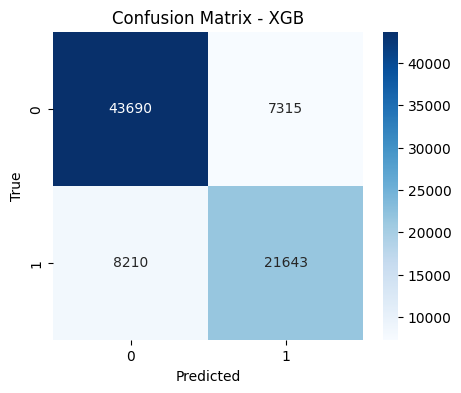

In [13]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGB")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


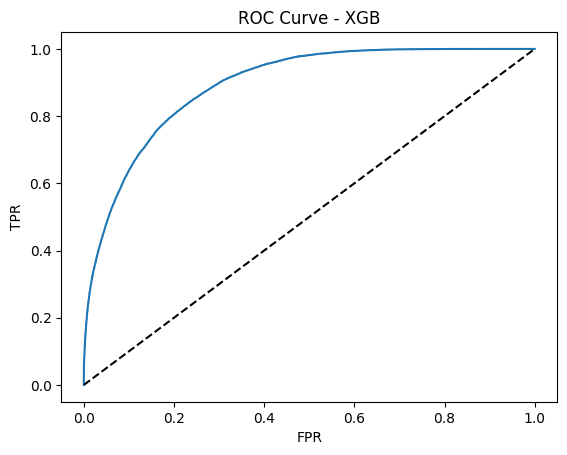

ROC-AUC: 0.8920544990618722


In [14]:
probs = best_xgb.predict_proba(X_test_vec)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve - XGB")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

print("ROC-AUC:", roc_auc_score(y_test, probs))


In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

models = {
    "Logistic Regression": lr,
    "SVM": svm,
    "XGBoost": best_xgb
}

results = []

for name, model in models.items():
    # Predict
    pred = model.predict(X_test_vec)

    # Metrics
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    results.append([name, acc, prec, rec, f1])

# Build comparison table
final_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

# Sort by F1 Score (best at top)
final_results = final_results.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

print("\n FINAL MODEL COMPARISON:\n")
print(final_results)



 FINAL MODEL COMPARISON:

                 Model  Accuracy  Precision    Recall  F1 Score
0                  SVM  0.813846   0.755551  0.732925  0.744066
1              XGBoost  0.807997   0.747393  0.724986  0.736019
2  Logistic Regression  0.774865   0.714633  0.649616  0.680576


In [16]:
import pickle

with open("tfidf_q1.pkl", "wb") as f:
    pickle.dump(tfidf_q1, f)

with open("tfidf_q2.pkl", "wb") as f:
    pickle.dump(tfidf_q2, f)

with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm, f)

with open("xgb_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

print("All models saved successfully!")


All models saved successfully!
